In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

2024-05-14 12:55:45.910288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 12:55:45.910430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 12:55:46.055991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/emotions/text.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB


In [4]:
df.isnull().sum()

Unnamed: 0    0
text          0
label         0
dtype: int64

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

Six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).

In [6]:
df['label'].value_counts()

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

In [7]:
stop_words = stopwords.words('english')

def data_cleaning(text):

    # Convert to lower
    text = text.lower()
    
    remove_stopwords = [word for word in text.split() if word not in stop_words]
    text = ' '.join(remove_stopwords)
    
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove digits
    text = re.sub(r"\d", '', text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)
    
    return text

In [8]:
df['cleaned_text'] = df['text'].apply(data_cleaning)

# Modeling

In [9]:
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
max_length = df['cleaned_text'].apply(lambda x: len(str(x).split())).max()

In [11]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

X_train.shape, X_test.shape

((333447, 79), (83362, 79))

In [12]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

In [13]:
# GLOVE_EMB = '/kaggle/input/glove6b300dtxt/glove.6B.300d.txt'

# Using smaller dimensions (50) to reduce the number of parameters
GLOVE_EMB = '/kaggle/input/glove-embeddings/glove.6B.50d.txt'

embeddings_index = {}

f = open(GLOVE_EMB , encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

#embeddings_index['the']

# EMBEDDING_DIM = 300
EMBEDDING_DIM = 50
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

Found 400000 word vectors.


In [14]:
embedding_matrix.shape

(75151, 50)

In [15]:
from tensorflow.keras import layers
from tensorflow.keras.initializers import Constant

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [16]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
#         self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Using pretrained Embedding layer
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, embeddings_initializer=Constant(embedding_matrix), input_length=maxlen, trainable=False)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [17]:
from tensorflow import keras
from tensorflow.keras import ops

# Using smaller dimensions (50) to reduce the number of parameters
embed_dim = 50  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(X_train.shape[1],))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)

transformer_block_1 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block_1(x)
transformer_block_2 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block_2(x)
# transformer_block_3 = TransformerBlock(embed_dim, num_heads, ff_dim)
# x = transformer_block_3(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.1)(x)
# x = layers.Dense(16, activation="relu")(x)
# x = layers.Dropout(0.1)(x)
outputs = layers.Dense(6, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 79)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 79, 50)         │     3,761,500 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 79, 50)         │        23,832 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 79, 50)         │        23,832 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,810,994 (14.54 MB)

 Trainable params: 53,444 (208.77 KB)

 Non-trainable params: 3,757,550 (14.33 MB)

In [19]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, show_trainable=True,show_layer_names=True)

In [20]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 611s 58ms/step - accuracy: 0.7709 - loss: 0.6257 - val_accuracy: 0.8710 - val_loss: 0.3012
Epoch 2/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 624s 58ms/step - accuracy: 0.8831 - loss: 0.2719 - val_accuracy: 0.8952 - val_loss: 0.2091
Epoch 3/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 600s 58ms/step - accuracy: 0.8954 - loss: 0.2197 - val_accuracy: 0.8980 - val_loss: 0.1960
Epoch 4/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 623s 58ms/step - accuracy: 0.8981 - loss: 0.2045 - val_accuracy: 0.8992 - val_loss: 0.1962
Epoch 5/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 605s 58ms/step - accuracy: 0.9002 - loss: 0.1985 - val_accuracy: 0.9025 - val_loss: 0.1846
Epoch 6/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 623s 58ms/step - accuracy: 0.9031 - loss: 0.1931 - val_accuracy: 0.9004 - val_loss: 0.1878
Epoch 7/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 608s 58ms/step - accuracy: 0.9042 - loss: 0.1894 - val_accuracy: 0.9021 - val_loss: 0.1825
Epoch 8/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 645s 62ms/s

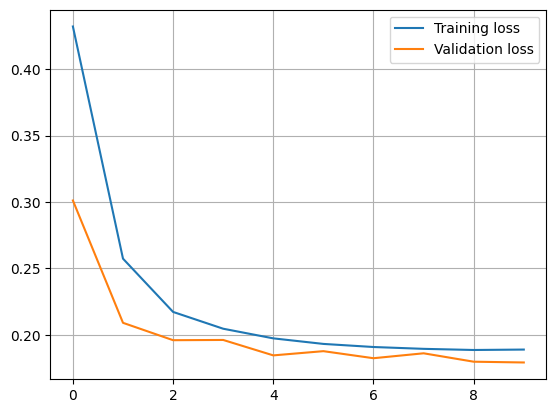

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")

plt.legend()
plt.grid()
plt.show() 

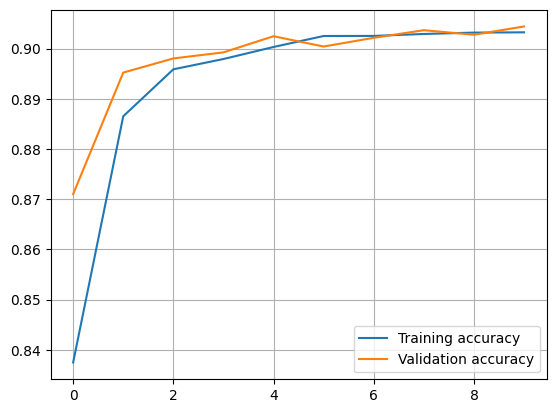

In [22]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(accuracy, label="Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")

plt.legend()
plt.grid()
plt.show()

Lets compare the first Ten true labels with their corresponding predicted labels.

In [23]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

# Convert y_test from one-hot encoded format like [0 0 1 0 0 0] to categorical labels by selecting the index with the value 1.
y_test = np.argmax(y_test, axis=1)

print(accuracy_score(y_pred, y_test))

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step
0.9044048847196564


In [24]:
comparison_df = pd.DataFrame()
comparison_df['y_pred'] = y_pred
comparison_df['y_test'] = y_test

comparison_df['y_pred'] = comparison_df['y_pred'].map({0:'sadness', 1:'joy', 2:'love', 3:'anger',4:'fear', 5: 'surprise'})
comparison_df['y_test'] = comparison_df['y_test'].map({0:'sadness', 1:'joy', 2:'love', 3:'anger',4:'fear', 5: 'surprise'})

In [25]:
# print first 10 predicted and true labels to have a look
comparison_df[:10]

,y_pred,y_test
0,love,love
1,fear,anger
2,joy,anger
3,anger,anger
4,fear,fear
5,joy,joy
6,joy,joy
7,joy,joy
8,sadness,sadness
9,joy,joy


<div style="color:white;
            display:fill;
            border-radius:15px;
            background-color:skyblue;
            font-size:100%;
            font-family:Verdana;
            letter-spacing:1px">
    <h2 style='padding: 20px;
              color:black;
              text-align:center;'>
        IF YOU LIKED THE NOTEBOOK PLEASE DO UPVOTE!  
    </h2>
    </div>